# Imports

In [ ]:
import os
import math
import zipfile
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_tuner as kt

# Data

In [2]:
train_dir = r"D:\Emotion_Detection\train"
test_dir = r"D:\Emotion_Detection\test"

- Problem: 
    - The purpose of this project is to build a deep learning convolutional neural network (CNN) that can process visual data and identify patterns so that it can sort different faces into different categories depending on the emotion the faces are exhibiting. 
- Link to Dataset
    - https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/data
- Dataset Size
    - The dataset contains 35,685 photos of 48x48 pixel gray scale divided into training and testing sets. Images are broken down into:
        - Happiness
        - Sadness 
        - Anger
        - Surprise 
        - Disgust
        - Fear
        - Neutral 

# Data EDA and Transforms

- There is no data cleaning that needs to be done because there is no missing information like matching photos with the correct emotion label for example
    - Photos are numbered and in a sub folder of the emotion type

- Data Preprocessing 
    - Build ImageDataGenerator using the Keras library to load the photos and apply emotion labels based on their folder heading 

- Data Augmentation (Things Tested)
    - Enhance photos to improve model generalization (on the training data only) using ImageDataGenerator class within Keras. Apply:
        - Resize 
            - Increase size from 48x48 to 2x,3x,4x etc
        - Rescale 
            - This normalizes pixel values to the range [0,1]
        - Rotation
            - This introduces variability which helps the model recognize objects regardless of orientation, this could help if data is not uniform
        - Width and Height shifting 
            - This simulates translations for better spatial recognition  
        - Sheer transformation
            - Simulates different perspectives with tilt
        - Zoom
            - This helps the model handle variations in scale 

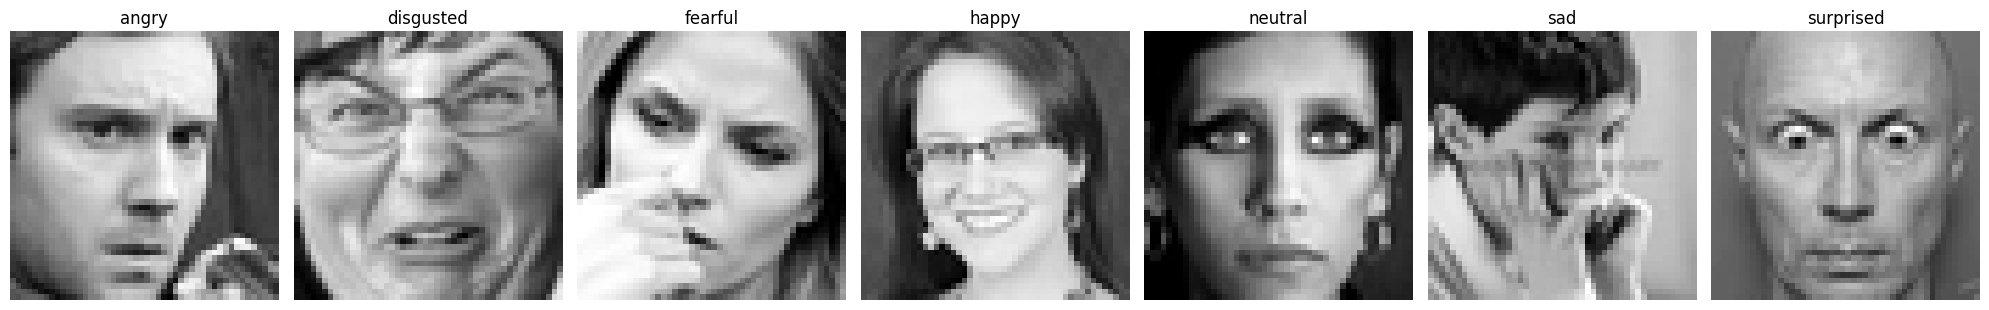

In [ ]:
# View Sample Photos From Each Emotion 

# Define emotion classes based on the dataset's folder structure
emotion_classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Number of images per class
num_images = 1  

# fig setup
fig, axes = plt.subplots(1, len(emotion_classes), figsize=(20, 8))

# Display 1 photo from each class
for idx, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(train_dir, emotion)
    image_files = os.listdir(emotion_path)
    
    if len(image_files) > 0:
        img_path = os.path.join(emotion_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axes[idx].imshow(img, cmap='gray')  # Display in grayscale
        axes[idx].set_title(emotion)
        axes[idx].axis('off')  # Hide axis

# Adjust the layout 
plt.tight_layout()
plt.show()




Class Distribution:
angry: 3995
disgusted: 436
fearful: 4097
happy: 7215
neutral: 4965
sad: 4830
surprised: 3171


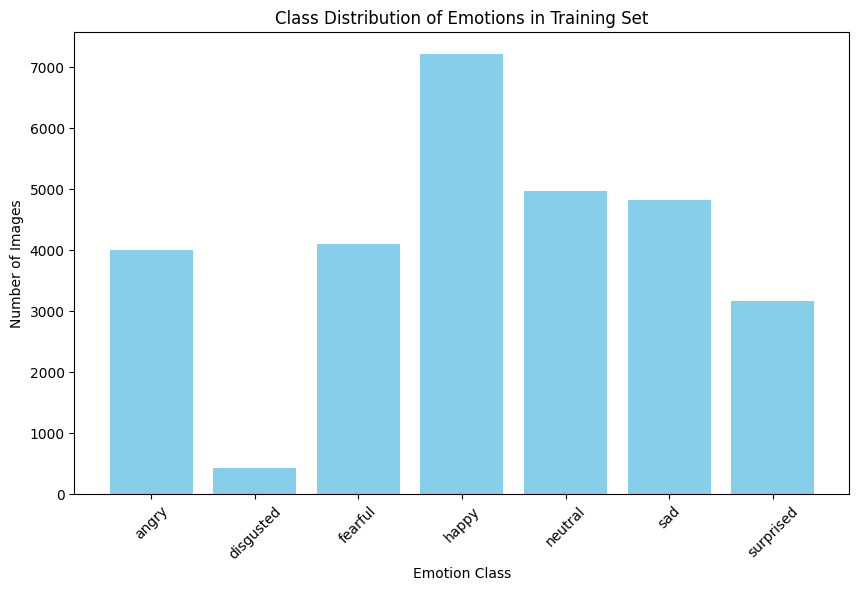

In [ ]:
# Dictionary for class counts
class_counts = {}

# Iterate over each emotion subfolder
for emotion in emotion_classes:
    # Get list of images in the emotion subfolder
    emotion_path = os.path.join(train_dir, emotion)
    image_files = os.listdir(emotion_path)
    
    # Count number of images
    class_counts[emotion] = len(image_files)

# Display class distribution
print("Class Distribution:")
for emotion, count in class_counts.items():
    print(f"{emotion}: {count}")

# Plot 
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Emotions in Training Set')
plt.xticks(rotation=45)
plt.show()

- A potential challenge for this project will be the extreme class imbalance between disgusted and happy. The counts of each class are:
    - Angry: 3995
    - Disgusted: 436
    - Fearful: 4097
    - Happy: 7215
    - Neutral: 4965
    - Sad: 4830
    - Surprised: 3171

- Advanced Data Augmentation techniques made the model perform much worse! I have archived the code below commented out but these are some of the things tried. I ended up using basic techniques like:

In [ ]:
"""
# Create ImageDataGenerator objects for training and testing
# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Random rotation between 0-20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.15,           # Shear transformation
    zoom_range=0.2,             # Random zoom in the images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill missing pixels with nearest values after transformations
)

# Validation/Test data generator (only normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate augmented training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),         # Resize images to 224x224
    color_mode='rgb',               # Switch to RGB 
    batch_size=32,                  # Number of images to process in a batch
    class_mode='categorical',       # Multi-class classification 
    shuffle=True                    # Shuffle the data to add randomness
)

# Generate validation/testing data without augmentation (just rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),         # Resize images to 224x224
    color_mode='rgb',               # Switch to RGB
    batch_size=32,
    class_mode='categorical',
    shuffle=False                   # Don't shuffle for validation/testing data
)
"""

- Data Preprocessing
    - Rescale photos by dividing pixel count by 255, this normalizes pixel values between [0,1] to improve training effeciency 
    - Apply RGB to enhance features 

In [5]:
# Create ImageDataGenerator objects for training and testing and rescale
train_data_gen = ImageDataGenerator(rescale=1./255)  
test_data_gen = ImageDataGenerator(rescale=1./255)   

In [6]:
# Flow From Dictionary parameter setup for ImageDataGenerator 
train_ffd = {
    'target_size': (48, 48),
    'color_mode': 'rgb',         
    'class_mode': 'categorical',
    'batch_size': 256,
    'shuffle': True              
}

test_ffd = {
    'target_size': (48, 48),
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'batch_size': 256,
    'shuffle': False             
}

In [7]:
# Load data using ImageDataGenerator 
train = train_data_gen.flow_from_directory(
    directory=train_dir,
    target_size=train_ffd['target_size'],
    color_mode=train_ffd['color_mode'],
    class_mode=train_ffd['class_mode'],
    batch_size=train_ffd['batch_size'],
    shuffle=train_ffd['shuffle']
)

test = test_data_gen.flow_from_directory(
    directory=test_dir,
    target_size=test_ffd['target_size'],
    color_mode=test_ffd['color_mode'],
    class_mode=test_ffd['class_mode'],
    batch_size=test_ffd['batch_size'],
    shuffle=test_ffd['shuffle']
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# CNN Model Building

- For this project I utilized my cancer detection CNN as a base model jumping off point because there are some similarities to this project as far as recognizing images and classifying them. My base model scored around 50% after tweaking the input and output layers as well as adding RGB support and rescaling. These results for emotion detection I thought were pretty good. These parameters were saved as baseline_ in the model building. Due to the exuberant training time required for this project I made a couple of assumptions to optimize my path forward after getting solid results from my modified cancer model:

    - Emotion detection is more complex than yes/no cancer detection and therefore the best way to improve my model’s performance was to make the model deeper. 
    - For hyperparameter tuning, the best model at epoch 10 would continue to be the best model when it was fully trained. While this is potentially missing out on some performance, I didn’t want to train for longer than 24 hours. 
    - To focus on improving they key characteristics of the model, I focused on the number of convolutional blocks, the number of filters in convolutional layers, kernel sizes, the number of dense layers and the number of units in dense layers. This I thought would give me the best chance to improve the model the most without leaving my PC running for three days straight. My hyperparameter tuning took about 22 hours!


In [ ]:
# Baseline Variables 
baseline_learning_rate = 5e-4  # Learning rate 
baseline_dropout_rate_conv = 0.2  # Dropout rate used in convolutional layers 
baseline_dropout_rate_dense = 0.5  # Dropout rate used in dense layers 
baseline_num_conv_blocks = 4  # Number of convolutional blocks 
baseline_conv_filters = [32, 64, 128, 256]  # Number of filters used in each Conv block 
baseline_kernel_size = (3, 3)  # Kernel size used in convolutional layers 
baseline_padding = 'same'  # Padding used in all Conv layers 
baseline_kernel_initializer = 'he_normal'  # Kernel initializer used for Conv and Dense layers
baseline_activation = 'relu'  # Activation function 
baseline_pool_size = (2, 2)  # Pooling size for all MaxPooling2D layers 
baseline_num_dense_layers = 2  # Number of dense layers 
baseline_dense_units = 64  # Number of units in each dense layer 
baseline_output_units = 7  # Number of output units (7 classes of emotions) 
baseline_output_activation = 'softmax'  # Activation function for the output layer 
baseline_input_shape = (48, 48, 3)  # Input shape of the first Conv2D layer 

# Experimental Variables 
exp_num_conv_blocks_range = [3, 4, 5]  # Experiment conv blocks range
exp_conv_filters_choices = [16, 32, 64, 128, 256, 512]  # Different filters numbers
exp_kernel_sizes_choices = [3, 5]  # Kernel sizes 
exp_num_dense_layers_range = [1, 2, 3]  # Dense Layer number
exp_dense_units_choices = [32, 64, 128, 256]  # Dense layer unit range


In [ ]:
# Function to build the model with hyperparameters for RandomSearch
def build_model(hp):
    model = Sequential()

    # Add convolutional and pooling layers
    num_conv_blocks = hp.Int('num_conv_blocks', min_value=min(exp_num_conv_blocks_range), max_value=max(exp_num_conv_blocks_range), default=baseline_num_conv_blocks)
    
    for i in range(num_conv_blocks):
        filters = hp.Choice(f'conv_{i+1}_filters', values=exp_conv_filters_choices, default=baseline_conv_filters[i] if i < len(baseline_conv_filters) else 32)
        kernel_size_choice = hp.Choice(f'conv_{i+1}_kernel_size', values=exp_kernel_sizes_choices, default=baseline_kernel_size[0])
        kernel_size = (kernel_size_choice, kernel_size_choice)  
        dropout_rate = baseline_dropout_rate_conv  

        model.add(Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding=baseline_padding,
            kernel_initializer=baseline_kernel_initializer,
            input_shape=baseline_input_shape if i == 0 else None
        ))
        model.add(Activation(baseline_activation))
        model.add(BatchNormalization())
        model.add(Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding=baseline_padding,
            kernel_initializer=baseline_kernel_initializer
        ))
        model.add(Activation(baseline_activation))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=baseline_pool_size))
        model.add(Dropout(rate=dropout_rate))

    model.add(Flatten())

    # Add dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=min(exp_num_dense_layers_range), max_value=max(exp_num_dense_layers_range), default=baseline_num_dense_layers)

    for j in range(num_dense_layers):
        units = hp.Choice(f'dense_{j+1}_units', values=exp_dense_units_choices, default=baseline_dense_units)
        dense_dropout_rate = baseline_dropout_rate_dense  # Fixed dropout rate from baseline for consistency

        model.add(Dense(units, kernel_initializer=baseline_kernel_initializer))
        model.add(Activation(baseline_activation))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dense_dropout_rate))

    # Output layer 
    model.add(Dense(baseline_output_units, kernel_initializer=baseline_kernel_initializer))
    model.add(Activation(baseline_output_activation))

    # Compile the model 
    model.compile(
        optimizer=Adam(learning_rate=baseline_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
# Setting up the Random Search tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='Emotion_Detection_11_26_24'
)


c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Start hyperparameter tuning using Random Search
tuner.search(
    train,
    validation_data=test,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]  # Early stopping to prevent overfitting
)

Trial 10 Complete [03h 28m 24s]
val_accuracy: 0.38896629214286804

Best val_accuracy So Far: 0.5526608824729919
Total elapsed time: 22h 01m 22s


In [12]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found
print(f"The best hyperparameters are: \n"
      f"Number of Convolutional Blocks: {best_hps.get('num_conv_blocks')}\n"
      f"Conv Filters: {[best_hps.get(f'conv_{i+1}_filters') for i in range(best_hps.get('num_conv_blocks'))]}\n"
      f"Number of Dense Layers: {best_hps.get('num_dense_layers')}\n"
      f"Dense Units: {[best_hps.get(f'dense_{j+1}_units') for j in range(best_hps.get('num_dense_layers'))]}\n")



The best hyperparameters are: 
Number of Convolutional Blocks: 4
Conv Filters: [32, 128, 128, 32]
Number of Dense Layers: 1
Dense Units: [64]



In [ ]:
# Best Hyperparameters Found from Random Search 
best_num_conv_blocks = 4
best_conv_filters = [32, 128, 128, 32]
best_num_dense_layers = 1
best_dense_units = 64

- Hyperparameters Tuning Summary

- For hyperameter tuning my model looped through a range of different hyperameter settings to optimize validation set accuracy. After getting decent results with my base model, I set to optimizing the complexity of the model due to the difficult task of emotion detection. I tested:
    - Number of Convolutional Blocks:
        - Values tested: [3, 4, 5]
    - Number of Filters in Convolutional Layers:
        - Filters were optimized at each of the convolutional blocks.
            - First Block: Values tested = [32, 64, 128]
            - Second Block: Values tested = [64, 128, 192, 256]
            - Third Block: Values tested = [128, 256, 512]
            - Fourth Block: Values tested = [32, 64, 128]
    - Kernel Size:
        - All Convolutional Blocks: Values tested = [(3, 3), (5, 5)]
    - Number of Dense Layers:
        - Values tested: [1, 2, 3]
    - Units in Dense Layers:
        - Dense Layers: Values tested = [32, 64, 128, 256]
    - Dropout Rate for Dense Layers:
        - Dense Layers: Values tested = [0.3, 0.4, 0.5, 0.6, 0.7]

- The tuning process took approximately 22 hours to complete, and after looping through these hyperparameters, the best-performing configuration included:
    - 4 Convolutional Blocks with filter values of [32, 128, 128, 32].
    - 1 Dense Layer with 64 units.
    - Fixed Dropout Rates for convolutional layers (0.2) and dense layers (0.5) 
    - The model was trained with a fixed learning rate of 5e-4.

In [ ]:
# Build Final Model with Best Parameters 

# Define the final model for Emotion Detection
emotion_detection_model = Sequential()

# Add convolutional and pooling layers
for i in range(best_num_conv_blocks):
    filters = best_conv_filters[i]
    
    emotion_detection_model.add(Conv2D(
        filters=filters,
        kernel_size=baseline_kernel_size,
        padding=baseline_padding,
        kernel_initializer=baseline_kernel_initializer,
        input_shape=baseline_input_shape if i == 0 else None
    ))
    emotion_detection_model.add(Activation(baseline_activation))
    emotion_detection_model.add(BatchNormalization())
    emotion_detection_model.add(Conv2D(
        filters=filters,
        kernel_size=baseline_kernel_size,
        padding=baseline_padding,
        kernel_initializer=baseline_kernel_initializer
    ))
    emotion_detection_model.add(Activation(baseline_activation))
    emotion_detection_model.add(BatchNormalization())
    emotion_detection_model.add(MaxPooling2D(pool_size=baseline_pool_size))
    emotion_detection_model.add(Dropout(rate=baseline_dropout_rate_conv))

emotion_detection_model.add(Flatten())

# Add dense layers
for j in range(best_num_dense_layers):
    emotion_detection_model.add(Dense(best_dense_units, kernel_initializer=baseline_kernel_initializer))
    emotion_detection_model.add(Activation(baseline_activation))
    emotion_detection_model.add(BatchNormalization())
    emotion_detection_model.add(Dropout(rate=baseline_dropout_rate_dense))

# Output layer 
emotion_detection_model.add(Dense(baseline_output_units, kernel_initializer=baseline_kernel_initializer))
emotion_detection_model.add(Activation(baseline_output_activation))

# Compile the model 
emotion_detection_model.compile(
    optimizer=Adam(learning_rate=baseline_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Model summary
emotion_detection_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 24, 24, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 557,799 (2.13 MB)

 Trainable params: 556,391 (2.12 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [31]:
# Train the final model until it stops improving 
history = emotion_detection_model.fit(
    train,
    validation_data=test,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 704ms/step - accuracy: 0.1646 - loss: 2.9751 - val_accuracy: 0.1772 - val_loss: 1.9874
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 682ms/step - accuracy: 0.2231 - loss: 2.2909 - val_accuracy: 0.2194 - val_loss: 1.8722
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 684ms/step - accuracy: 0.2826 - loss: 2.0274 - val_accuracy: 0.3183 - val_loss: 1.7345
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 78s 687ms/step - accuracy: 0.3463 - loss: 1.8107 - val_accuracy: 0.3820 - val_loss: 1.6020
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 78s 687ms/step - accuracy: 0.3920 - loss: 1.6831 - val_accuracy: 0.3884 - val_loss: 1.6125
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 685ms/step - accuracy: 0.4141 - loss: 1.5798 - val_accuracy: 0.4487 - val_loss: 1.4415
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 682ms/step - accuracy: 0.4319 - loss: 1.5249 - val_accuracy: 0.4738 - val_loss: 1.3607
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 684ms/step - accuracy: 0.4549 - loss: 1

# Model Architecture 

-	Input Layer
    - Input Shape: (48, 48, 3)
    - The model accepts 48x48 pixel images in RGB format.
-	Convolutional Block 1
    -	Conv2D Layer
        -	Filters: 32
        -	Kernel Size: (3, 3)
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	Conv2D Layer
        -	Filters: 32
        -	Kernel Size: (3, 3)
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	MaxPooling2D Layer
        -	Pool Size: (2, 2)
    -	Dropout Layer
        -	Rate: 0.2
-	Convolutional Block 2
    -	Conv2D Layer
        -	Filters: 128
        -	Kernel Size: (3, 3)
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	Conv2D Layer
        -	Filters: 128
        -	Kernel Size: (3, 3)
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	MaxPooling2D Layer
        -	Pool Size: (2, 2)
    -	Dropout Layer
        -	Rate: 0.2
-	Convolutional Block 3
    -	Conv2D Layer
        -	Filters: 128
        -	Kernel Size: (3, 3)
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	Conv2D Layer
        -	Filters: 128
        -	Kernel Size: (3, 3)
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	MaxPooling2D Layer
        -	Pool Size: (2, 2)
    -	Dropout Layer
        -	Rate: 0.2
-	Convolutional Block 4
    -	Conv2D Layer
        -	Filters: 32
        -	Kernel Size: (3, 3)
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	Conv2D Layer
        -	Filters: 32
        -	Kernel Size: (3, 3)
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	MaxPooling2D Layer
        -	Pool Size: (2, 2)
    -	Dropout Layer
        -	Rate: 0.2
-	Flatten Layer
    -	Converts the 2D feature maps into a 1D feature vector.
-	Fully Connected Layer
    -	Dense Layer
        -	Units: 64
        -	Activation: ReLU
    -	Batch Normalization Layer
        -	Normalizes the output of the previous layer.
    -	Dropout Layer
        -	Rate: 0.5
-	 Output Layer
    -	Dense Layer
        -	Units: 7 
        -	Activation: Softmax
        -	Provides a probability distribution across the 7 classes.


# Model Layer Explanation

- Convolutional Layers
    - The purpose of the convolutional layers is to extract spatial features by applying filters to the input. As the model increases in layers, the number of filters increases, deeper layers will then capture more complex patterns. The ReLU activation function provides non-linearity, which allows the model pickup on relationships that are not only linear. This model needed many convolutional layers to pick up on the sometimes subtle facial feature shifts between emotions. 

- MaxPooling Layers
    - The MaxPooling layers reduce the spatial dimensions of the feature maps. This lowers computational cost and helps with overfitting.

- Batch Normalization
    - The Batch Normalization layers normalize the output of the previous layer, I did not find much change in performance by changing this. 

- Flatten Layer
    - The Flatten Layer transforms the 2D feature maps into a 1D vector to prepare the data for the fully connected layers.

- Fully Connected Layers
    - The fully connected layers use dense units to learn high-level features from the extracted feature maps. In my final model I used a 64-unit dense layer to capture high-level representations. A dropout layer is applied to prevent overfitting as well.

- Output Layer
    - The output layer produces a probability distribution over the 7 classes of emotions which then takes the highest value to assign the emotion.

# Final Model Results

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.5868 - loss: 1.9975
Test Loss: 1.635303258895874
Test Accuracy: 0.6390359401702881


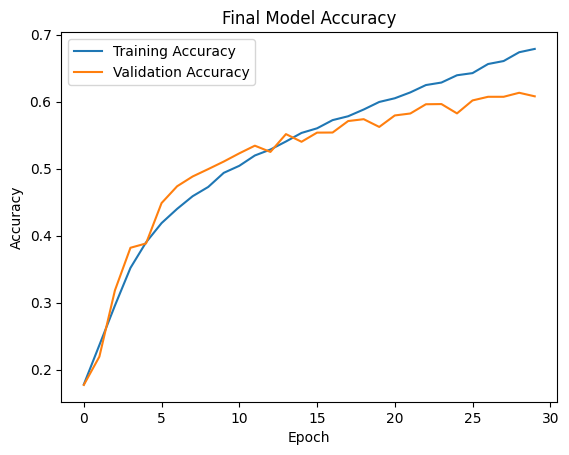

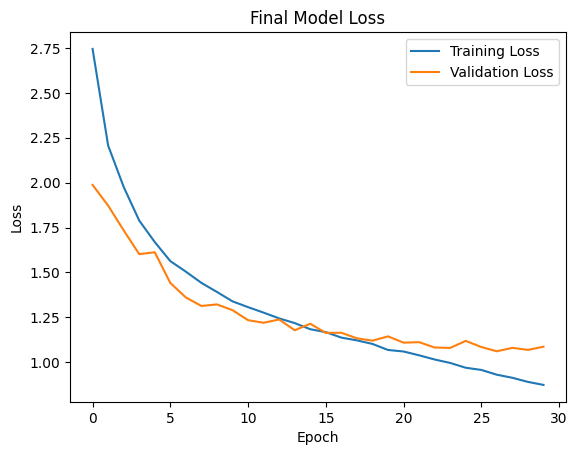

In [ ]:
# Evaluate the final model using the test set
test_loss, test_accuracy = final_model.evaluate(test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot Accuracy Training Metric
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss Training Metric
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step


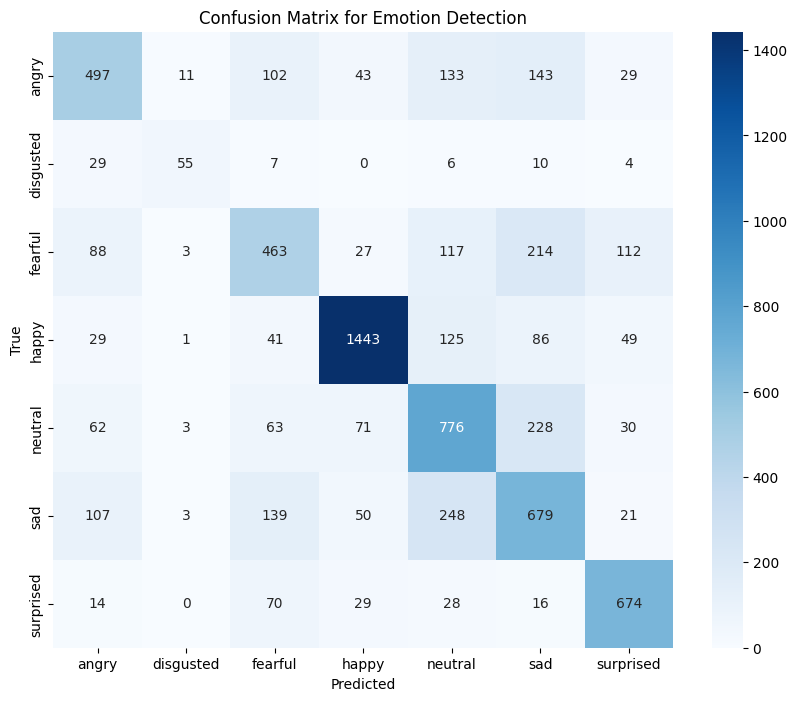

Classification Report:
               precision    recall  f1-score   support

       angry       0.60      0.52      0.56       958
   disgusted       0.72      0.50      0.59       111
     fearful       0.52      0.45      0.49      1024
       happy       0.87      0.81      0.84      1774
     neutral       0.54      0.63      0.58      1233
         sad       0.49      0.54      0.52      1247
   surprised       0.73      0.81      0.77       831

    accuracy                           0.64      7178
   macro avg       0.64      0.61      0.62      7178
weighted avg       0.64      0.64      0.64      7178



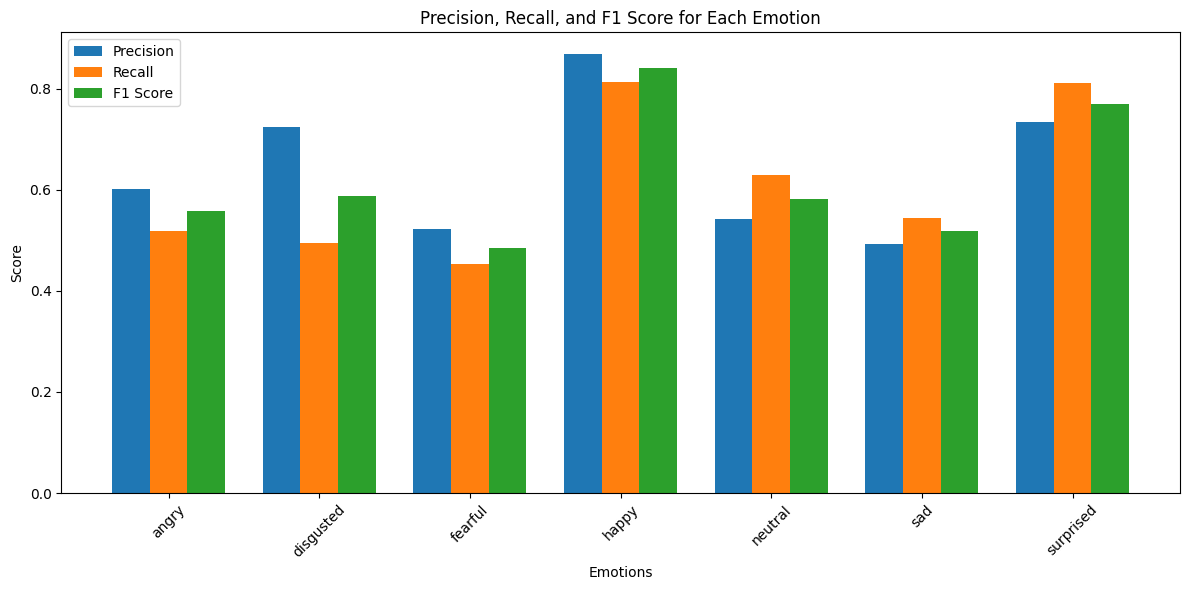

In [ ]:
# Make predictions on the test set
y_pred = final_model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test.classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=test.class_indices, yticklabels=test.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Emotion Detection')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=list(test.class_indices.keys()))
print("Classification Report:\n", class_report)

# Plot Precision, Recall, and F1 Score for each emotion
report_dict = classification_report(y_true, y_pred_classes, target_names=list(test.class_indices.keys()), output_dict=True)
emotions = list(report_dict.keys())[:-3]  # Remove 'accuracy', 'macro avg', and 'weighted avg'
precision = [report_dict[emotion]['precision'] for emotion in emotions]
recall = [report_dict[emotion]['recall'] for emotion in emotions]
f1_score = [report_dict[emotion]['f1-score'] for emotion in emotions]

x = np.arange(len(emotions))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1 Score')

plt.xlabel('Emotions')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score for Each Emotion')
plt.xticks(ticks=x, labels=emotions, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Conclusion 

- I think a final score of 64% average accuracy for facial recognition is pretty good. It is notoriously tricky for computers to pick up on the subtle differences between different emotions. If you look at my results the more positive emotions which are more distinct the model sorts quite well like surprise and happiness while there is more convolution between anger, sadness and fear.  
- To improve my project, I think I need an even more complex model and different data. I tried data augmentation to try and help the model pick up on the differences in facial features with emotions that have some overlap like fear and anger for example, but it made my model perform worse. I think this was due to the data being homogenous. It was already in an idealized state, and I added complexity that harmed the model performance as opposed to exaggerating the features I was trying to enhance. 

